In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read as readWav
from scipy.io.wavfile import write as writeWav
from scipy.signal import spectrogram, get_window
from scipy.fftpack import fft, ifft

from scipy.signal import butter, lfilter, freqz, filtfilt

# want 195 Hz low pass

def lowPass(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normed_cutoff = cutoff / nyquist
    b, a = butter(order, normed_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    yalt = filtfilt(b, a, data)
    return y

def getWav(name):
    fs, audio = readWav(name)
    tStep = 1.0/fs
    t = [tStep*n for n in range(len(audio))]
    return fs, audio, t

#def saveWave(data, fs, name):
#    writeWav(fname, fs, data)
    
# Data published on Kaggle: https://www.kaggle.com/kinguistics/heartbeat-sounds
    
audio = getWav("heartbeat-sounds/set_a/murmur__201101051108.wav")

print (audio[1].dtype)

audio2 = getWav("heartbeat-sounds/set_b/Bunlabelledtest__101_1305030823364_A.wav")

print (audio2[1].dtype)

filteredAudio = lowPass(audio[1], 195, audio[0])
filteredAudio2 = lowPass(audio2[1], 195, audio2[0])

writeWav("heartbeat-sounds-filtered/set_a/normal_201106141148_filtered.wav", audio[0], filteredAudio)
writeWav("heartbeat-sounds-filtered/set_a/normal_201106141148.wav", audio[0], audio[1])
#audio = readWav("heartbeat-sounds/set_a/normal__201106141148.wav")


int16
int16


FileNotFoundError: [Errno 2] No such file or directory: 'heartbeat-sounds-filtered/set_a/normal_201106141148_filtered.wav'

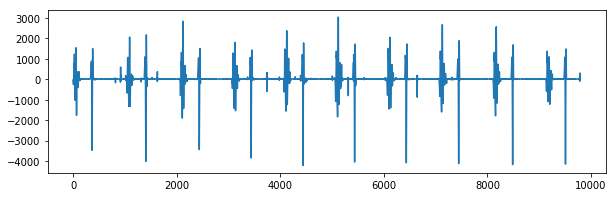

In [4]:
from scipy.signal import decimate

center = 10021
width = 3000

decFac = 40

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
sig = decimate(audio[1], decFac, ftype='fir', axis=0, zero_phase=True)

ax.plot(sig)
#plt.plot(audio[2], filteredAudio)
#plt.plot(audio2[2], audio2[1])
#plt.plot(audio2[2], filteredAudio2)
plt.show()

/home/Kyle/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


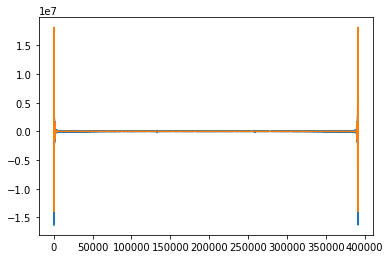

In [5]:
audioFreq = fft(audio[1])
audioFiltFreq = fft(filteredAudio)
plt.plot(audioFreq)
plt.plot(audioFiltFreq)
plt.show()

audio signal length  391787
frequency points  129


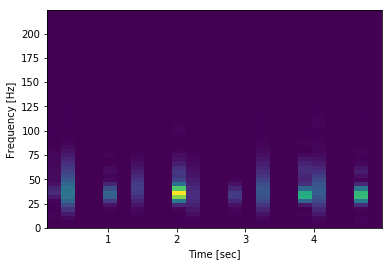

In [6]:
def procSpectrograph(f, t, Sxx, cutoff, duration):
    # a little inefficient - only need first case
    icut = np.where(f > cutoff)
    jcut = np.where(t > duration)
    f_cut = f[:icut[0][0]]
    t_cut = t[:jcut[0][0]]
    Sxx_cut = Sxx[:icut[0][0],:jcut[0][0]]
    return f_cut, t_cut, Sxx_cut

print ("audio signal length ", len(audio[1]))
#f1, t1, audioSpec1 = spectrogram(sig, fs=audio2[0]/decFac, nperseg=1024)
f1, t1, audioSpec1 = spectrogram(sig, fs=audio[0]/decFac, window=('hamming'))
print ("frequency points ", len(audioSpec1))

f2, t2, audioSpec2 = procSpectrograph(f1, t1, audioSpec1, 225, 5.0)

#ax = plt.pcolormesh(t, f[:15], audioSpec[:15, ::])
#ax = plt.pcolormesh(t2*decFac, f2, audioSpec2)
ax = plt.pcolormesh(t2, f2, audioSpec2)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

audio signal length  391787
6615 2205
Window length =  6615
frequency points  3308


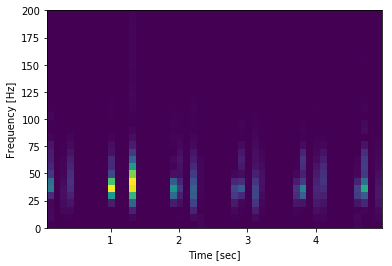

In [7]:
print ("audio signal length ", len(audio[1]))
#f1, t1, audioSpec1 = spectrogram(sig, fs=audio2[0]/decFac, nperseg=1024)

deltaT = 0.150
overlap = 0.050

sampleWidth = int(np.floor(deltaT*audio[0]))
sampleOverlap = int(np.floor(overlap*audio[0]))
print (sampleWidth, sampleOverlap)

win = get_window('hamming', Nx = sampleWidth)

print ('Window length = ', len(win))

f1, t1, audioSpec1 = spectrogram(audio[1], fs=audio[0], window=win, noverlap=sampleOverlap, scaling='density')
print ("frequency points ", len(audioSpec1))

f2, t2, audioSpec2 = procSpectrograph(f1, t1, audioSpec1, 200, duration=5.0)

#ax = plt.pcolormesh(t, f[:15], audioSpec[:15, ::])
#ax = plt.pcolormesh(t2*decFac, f2, audioSpec2)

#ax = plt.pcolormesh(t2, f2, audioSpec2, shading='gouraud')
ax = plt.pcolormesh(t2, f2, audioSpec2)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

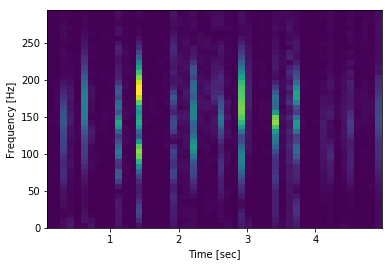

In [8]:
def waveToSpec(WAVname, timeInt, timeOverlap, duration=5.0, dispLimit=300, dec=True, decFac=40):
    fs, audio, _ = getWav(WAVname)
    
    if dec:
        sig = decimate(audio, decFac, ftype='fir', axis=0, zero_phase=True)
        fs = fs / decFac
    else:
        sig = audio
    
    sampleWidth = int(np.floor(timeInt*fs))
    sampleOverlap = int(np.floor(overlap*fs))

    win = get_window(('chebwin', 100), Nx = sampleWidth)
    
    f, t, audioSpec = spectrogram(sig, fs=fs, window=win, noverlap=sampleOverlap, scaling='density', mode='magnitude', )
    f2, t2, audioSpec2 = procSpectrograph(f, t, audioSpec, dispLimit, duration)
    
    return f2, t2, audioSpec2
    
wavPath = 'heartbeat-sounds/set_a/'
    
wavName = 'heartbeat-sounds/set_a/normal__201102201230.wav'
#wavName = 'heartbeat-sounds/set_a/normal__201105021804.wav'
#wavName = wavPath + 'normal__201101151127.wav'
#wavName = wavPath + 'murmur__201108222251.wav'
#wavName = wavPath +'extrahls__201102070251.wav'
#wavName = wavPath +'artifact__201106221254.wav'
#wavName = wavPath + 'artifact__201106021541.wav'

t,f,audioSpec = waveToSpec(wavName, 0.150, 0.1, duration=5.0, dispLimit=300, dec=True, decFac=30)
ax = plt.pcolormesh(f, t, audioSpec)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
        

In [19]:
import pandas as pd

debug = False

topDir = 'heartbeat-sounds/'

A_CSV = pd.read_csv(topDir + 'set_a.csv')
A_CSV.drop(['sublabel'], axis=1, inplace=True)


print (A_CSV.head(), A_CSV.tail())

file_indexed_A_CSV = A_CSV.set_index(['fname'])

spectrograms = []

shortFiles = []

for name in A_CSV.fname:
    if (debug):
        print (name)
    try:
        t,f,audioSpec = waveToSpec(topDir + name, 0.10, 0.1 / 3, duration=5.0, dispLimit=300, dec=True)
        #spectrograms.append(audioSpec.flatten('C'))
        spectrograms.append(audioSpec)
    except:
        shortFiles.append(name) # we will simply remove these later
        
file_indexed_A_CSV.drop(shortFiles, inplace=True)

  dataset                             fname     label
0       a  set_a/artifact__201012172012.wav  artifact
1       a  set_a/artifact__201105040918.wav  artifact
2       a  set_a/artifact__201105041959.wav  artifact
3       a  set_a/artifact__201105051017.wav  artifact
4       a  set_a/artifact__201105060108.wav  artifact     dataset                     fname label
171       a  set_a/__201108222241.wav   NaN
172       a  set_a/__201108222244.wav   NaN
173       a  set_a/__201108222247.wav   NaN
174       a  set_a/__201108222254.wav   NaN
175       a  set_a/__201108222257.wav   NaN


In [1]:
'''from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = file_indexed_A_CSV['label']
X = spectrograms

Settings = {'activation' : 'logistic'}

model = MLPClassifier(Settings)

Xtrain, Xval, ytrain, yval = train_test_split(X, y)

model.fit(Xtrain, ytrain)

yPred = model.predict(Xval)

print (accuracy_score(yPred, yVal))'''

"from sklearn.neural_network import MLPClassifier\n\nfrom sklearn.metrics import mean_absolute_error\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.model_selection import train_test_split\n\ny = file_indexed_A_CSV['label']\nX = spectrograms\n\nSettings = {'activation' : 'logistic'}\n\nmodel = MLPClassifier(Settings)\n\nXtrain, Xval, ytrain, yval = train_test_split(X, y)\n\nmodel.fit(Xtrain, ytrain)\n\nyPred = model.predict(Xval)\n\nprint (accuracy_score(yPred, yVal))"

In [10]:
from IPython.display import Audio
import librosa.display

Audio(wavPath + 'murmur__201108222251.wav')

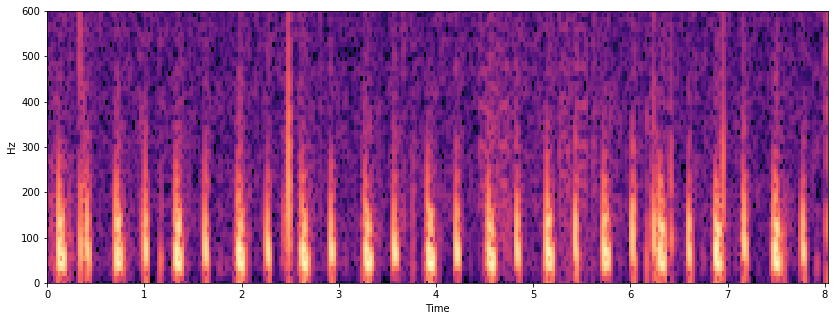

In [17]:
def dispSpgrph(fname, yLimit, xRange=None):
    z, sr = librosa.load(fname)
    Z = librosa.stft(z)
    Zdb = librosa.amplitude_to_db(abs(Z))
    plt.figure(figsize=(14, 5))
    ax = librosa.display.specshow(Zdb, sr=sr, x_axis='time', y_axis='hz')
    ax.set_ylim((0,yLimit))
    if xRange is not None:
        ax.set_xlim(xRange)

#dispSpgrph(wavPath + 'murmur__201108222251.wav' , 600)       
dispSpgrph(wavPath + 'normal__201103090635.wav', 600)

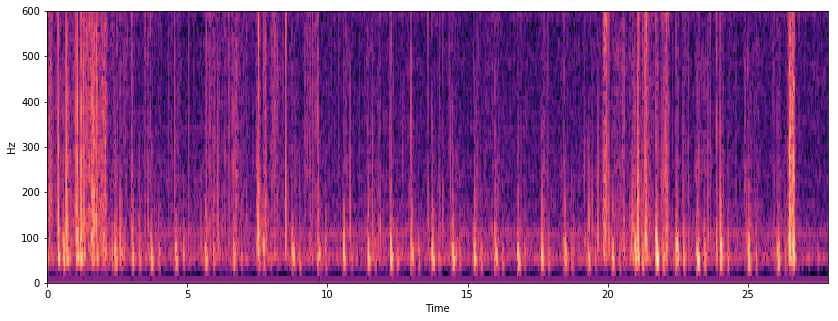

In [15]:
dispSpgrph('heartbeat-sounds/recorded/Audio_recording_2018-03-24_23-02-43.wav', 600)

In [47]:
Audio('heartbeat-sounds/recorded/Audio_recording_2018-03-24_23-02-43.wav')